In [1]:
import json
import numpy 
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import pyarrow
import sys
from tqdm import tqdm
import seaborn as sns
from datetime import date
from dotenv import load_dotenv
from sqlalchemy import create_engine
from os import path
from typing import List,Dict, Tuple
from collections import defaultdict
pd.set_option("display.max_columns", None)

load_dotenv(verbose=True)
BIGQUERY_CREDENTIALS_PATH = os.environ.get('BIGQUERY_CREDENTIALS_PATH')
engine = create_engine('bigquery://bespoke-financial/ProdMetrcData', credentials_path=os.path.expanduser(BIGQUERY_CREDENTIALS_PATH))

sys.path.append(path.realpath(path.join(os.getcwd(), "../core")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../src")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../scripts")))

import create_queries
import prepare_data

from bespoke.inventory.analysis.shared import download_util, inventory_types
from bespoke.inventory.analysis import active_inventory_util as util
from bespoke.inventory.analysis import inventory_valuations_util as valuations_util
from underwriting import msrp_band_analyzer

%load_ext autoreload
%autoreload 2

/Users/victoria/GitHub/venvs/bespoke/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [21]:
mba = msrp_band_analyzer.MSRPBand()

In [25]:
mba.update_company_data(['EL'])


Verifying download summaries for license C9-0000370-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-03-14

[SUCCESS] All download summaries look good!
[SUCCESS] No unknown transfer packages!
98.0% of incoming transfer packages have receiver wholesale price
# transactions missing incoming transfer package: 0 (0.0%)
# transactions total: 20415
# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 7987
### Adding new columns calculated by average price per unit ### 	
### Sorting time series ### 	
### Removing NAs from product category row ### 	
### Combining same product categories with different measurements ### 	
### Available combined product category name in costs dataframe ### 	
['vape cartridge' 'tincture' 'edible' 'extract' 'pre-roll flower' 'flower'
 'other concentrate' 'pre-roll leaf' 'topical' 'capsule'
 'pre-roll infused' 'shake']
### Available combined product category name in sales dataframe #

/Users/victoria/dev/platform/services/api-server/scripts/underwriting/msrp_band_analyzer.py:276: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[measure_ratio_column_name][includes_measurement] = self.unit_conversion_ratio(measurement, measurement_unit)
/Users/victoria/dev/platform/services/api-server/scripts/underwriting/msrp_band_analyzer.py:276: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[measure_ratio_column_name][includes_measurement] = self.unit_conversion_ratio(measurement, measurement_unit)
/Users/victoria/dev/platform/services/api-server/scripts/underwriting/msrp_band_analyzer.py:276: SettingWithCopyWarn

In [12]:
mba.company_sales_df[mba.company_sales_df['tx_product_category_name'] == 'Other Concentrate (weight - each)']['tx_price_per_unit'].quantile(0.99)

96.73499999999981

In [10]:
mba.company_sales_df[mba.company_sales_df['tx_product_category_name'] == 'Other Concentrate (weight - each)']['tx_price_per_unit'].describe()

count    1268.000000
mean       28.075359
std        15.609330
min         0.000000
25%        22.960000
50%        27.330000
75%        34.622500
max       100.230000
Name: tx_price_per_unit, dtype: float64

/Users/victoria/GitHub/venvs/bespoke/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='tx_price_per_unit'>

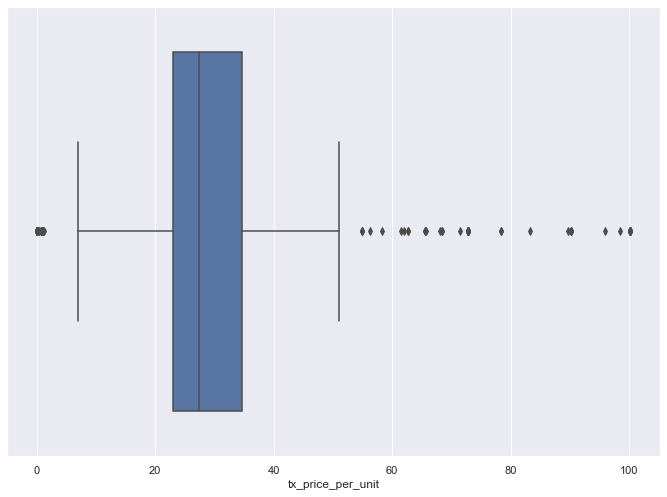

In [13]:
sns.boxplot(mba.company_sales_df[mba.company_sales_df['tx_product_category_name'] == 'Other Concentrate (weight - each)']['tx_price_per_unit'])

In [18]:
mba.company_sales_df['tx_product_category_name'].unique()

array(['Pre-Roll Flower', 'Tincture (volume - each)',
       'Topical (weight - each)', 'Edible (volume - each)',
       'Flower (packaged eighth - each)', 'Capsule (weight - each)',
       'Vape Cartridge (weight - each)', 'Edible (weight - each)',
       'Topical (volume - each)', 'Extract (weight - each)',
       'Pre-Roll Infused', 'Flower (packaged half ounce - each)',
       'Pre-Roll Leaf', 'Vape Cartridge (volume - each)',
       'Other Concentrate (weight - each)',
       'Flower (packaged gram - each)',
       'Flower (packaged quarter - each)', 'Flower (packaged - each)',
       'Other Concentrate (volume - each)',
       'Shake (Packaged Gram - each)', 'Tincture (weight - each)',
       'Flower (packaged ounce - each)',
       'Infused Butter/Oil (weight - each)',
       'Shake (Packaged Eighth - each)', 'Seeds (each)',
       'Shake (Packaged Ounce - each)', 'Extract (volume - each)',
       'Shake (Packaged Half Ounce - each)',
       'Infused Butter/Oil (volume - each)']

In [55]:
mba.company_sales_df[mba.company_sales_df['tx_unit_of_measure'] != 'Grams']




,license_number,receipt_number,rt_type,sales_customer_type,sales_datetime,sales_month,total_packages,rt_total_price,tx_type,tx_package_id,tx_package_label,tx_product_name,tx_product_category_name,tx_unit_of_measure,tx_quantity_sold,tx_total_price,tx_price_per_unit,date_in_month,adjusted_tx_price_per_unit,measurement_ratio_vs_gram,combined_product_category
20414,C9-0000370-LIC,0047837378,active,Consumer,2020-09-10 19:10:17+00:00,2020-09,3,99.00,active,7548982,1A40603000092E5000080140,Higher: 100mg Crackers (10 Pack): Rosemary Garlic,Edible (weight - each),Each,1.0,27.0,27.0,2020-09,27.000000,1.0,edible
20314,C9-0000370-LIC,0050947332,active,Patient,2020-09-26 21:30:10+00:00,2020-09,5,171.00,active,8162938,1A4060300008D22000082908,Honeyleaf Smalls - Indica - 7.0g pouch,Flower (packaged quarter - each),Each,1.0,50.0,50.0,2020-09,7.142857,7.0,flower
20315,C9-0000370-LIC,0050947332,active,Patient,2020-09-26 21:30:10+00:00,2020-09,5,171.00,active,7746174,1A406030000866A000009703,|PREROLL| Single (1.0 g) - I - Orange Cookies,Pre-Roll Leaf,Each,1.0,1.0,1.0,2020-09,1.000000,1.0,pre-roll leaf
20316,C9-0000370-LIC,0050947332,active,Patient,2020-09-26 21:30:10+00:00,2020-09,5,171.00,active,7686754,1A4060300005B14000107774,Kings Garden Platinum Blue Dream Flower Prepac...,Flower (packaged eighth - each),Each,1.0,50.0,50.0,2020-09,14.285714,3.5,flower
20317,C9-0000370-LIC,0050947332,active,Patient,2020-09-26 21:30:10+00:00,2020-09,5,171.00,active,7737297,1A4060300004975000097136,Buddies - Sundae Driver X Mendo Breath - 1g Di...,Vape Cartridge (weight - each),Each,1.0,40.0,40.0,2020-09,40.000000,1.0,vape cartridge
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,C9-0000370-LIC,0169424665,active,Consumer,2022-03-04 17:56:16+00:00,2022-03,2,70.00,active,22559679,1A4060300006D67000059132,Hush - Distillate Cart - Clementine - 1g,Vape Cartridge (weight - each),Each,1.0,35.0,35.0,2022-03,35.000000,1.0,vape cartridge
358,C9-0000370-LIC,0169424665,active,Consumer,2022-03-04 17:56:16+00:00,2022-03,2,70.00,active,16000891,1A406030000F2FB000012506,Blueberry Cannavis Syrup - 2oz (300mg),Tincture (volume - each),Each,1.0,35.0,35.0,2022-03,35.000000,1.0,tincture
359,C9-0000370-LIC,0169424654,active,Consumer,2022-03-04 17:29:48+00:00,2022-03,5,90.34,active,14804807,1A4060300022B79000069548,"Sanna Sleep Gel Capsules 6pc, Hashtag Distribu...",Capsule (weight - each),Each,1.0,9.6,9.6,2022-03,9.600000,1.0,capsule
361,C9-0000370-LIC,0169424654,active,Consumer,2022-03-04 17:29:48+00:00,2022-03,5,90.34,active,22290682,1A4060300006E2E000127462,KE - CBD Apple 20:1 - 43g,Edible (weight - each),Each,1.0,22.5,22.5,2022-03,22.500000,1.0,edible
